In [1]:
import torch
import torch.nn as nn
import string
import random
import sys
import os
import pandas as pd
import numpy as np

In [2]:
import unidecode
from torch.utils.tensorboard import SummaryWriter

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [6]:
# Get characters: 
all_characters = string.printable
n_characters = len(all_characters)
print(all_characters)
print(n_characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

100


In [7]:
df = pd.read_csv('lox_basic.csv')

In [8]:
df_data = df.iloc[:,1]

In [9]:
df_data
print(type(df_data))

<class 'pandas.core.series.Series'>


In [10]:
df_data

0          O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O
1         Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1
2                 CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1
3      O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...
4            COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O
                             ...                        
503                 FC(F)(F)c1ccc(CSc2nccn2-c2ccccc2)cc1
504                       Brc1ccc(CSc2nccn2-c2ccccc2)cc1
505                       CCc1ccc(CSc2nccn2-c2ccccc2)cc1
506    COc1cccc(CNc2ccc(S(=O)(=O)Nc3nc4c(ccc5ccccc54)...
507    CCCCCCCCOC(=O)NS(=O)(=O)Nc1cc(-c2cc3ccccc3[nH]...
Name: canonical_smiles, Length: 508, dtype: object

In [11]:
df_data = df_data.to_frame(name='canonical_smiles')

In [12]:
df_data

,canonical_smiles
0,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O
1,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1
2,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1
3,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...
4,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O
...,...
503,FC(F)(F)c1ccc(CSc2nccn2-c2ccccc2)cc1
504,Brc1ccc(CSc2nccn2-c2ccccc2)cc1
505,CCc1ccc(CSc2nccn2-c2ccccc2)cc1
506,COc1cccc(CNc2ccc(S(=O)(=O)Nc3nc4c(ccc5ccccc54)...


In [26]:
df_data

,canonical_smiles
0,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O
1,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1
2,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1
3,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...
4,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O
...,...
503,FC(F)(F)c1ccc(CSc2nccn2-c2ccccc2)cc1
504,Brc1ccc(CSc2nccn2-c2ccccc2)cc1
505,CCc1ccc(CSc2nccn2-c2ccccc2)cc1
506,COc1cccc(CNc2ccc(S(=O)(=O)Nc3nc4c(ccc5ccccc54)...


In [13]:
#EDA 
df_data.duplicated().sum()

0

In [14]:
df_data.isna().sum()

canonical_smiles    0
dtype: int64

In [15]:
df_data.isnull().sum()

canonical_smiles    0
dtype: int64

In [16]:
df_data.to_csv(r'SMILES.txt', header=None, index=None, sep=" ", mode='a')

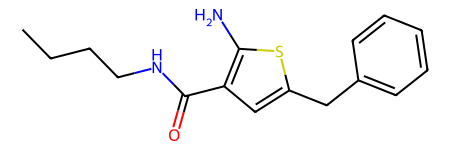

In [17]:
Chem.MolFromSmiles(df_data.canonical_smiles[400])

In [18]:
for i in range(len(df_data)):
    Chem.MolFromSmiles(df_data.canonical_smiles[i])

In [20]:
file = unidecode.unidecode(open('SMILES.txt').read())

In [19]:
#LSTM

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        #Create embedding for each character that will be learned by the model
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden, cell):
        out = self.embed(x)
        out,(hidden,cell) = self.lstm(out.unsqueeze(1), (hidden,cell)) #make shape match
        out = self.fc(out.reshape(out.shape[0],-1)) #unrolls the shape
        return out, (hidden,cell)
    
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [21]:
class LSTM_Generator(nn.Module):
    
    def __init__(self, chunk_len = 250, epochs = 5000, batch_size = 1, print_every = 200, hidden_size = 256,
                num_layers = 2, lr = 0.003, seed = 42):
        
        super(LSTM_Generator, self).__init__()
        
        self.chunk_len = chunk_len
        self.epochs = epochs
        self.batch_size = batch_size 
        self.print_every = print_every
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.lr = lr 
        self.seed = seed 
        
        set_seed(self.seed) #for reproducibility
        
        
    def char_tensor(self, string):
        
        tensor = torch.zeros(len(string)).long()
        for c in range(len(string)):
            tensor[c] = all_characters.index(string[c])
            
        return tensor
        
        
    def get_random_batch(self):
        start_idx = random.randint(0, len(file) - self.chunk_len)
        end_idx = start_idx + self.chunk_len + 1 
        text_str = file[start_idx:end_idx]
        text_input = torch.zeros(self.batch_size, self.chunk_len)
        text_target = torch.zeros(self.batch_size, self.chunk_len)
        
        
        for i in range(self.batch_size):
            text_input[i,:] = self.char_tensor(text_str[:-1])
            text_target[i,:] = self.char_tensor(text_str[1:])
            
        return text_input.long(), text_target.long()
        
        
    def generate(self, initial_str='C', prediction_len=100, temperature=0.85, seed=42):
        set_seed(self.seed)
        
        hidden, cell = self.rnn.init_hidden(batch_size = self.batch_size)
        initial_input = self.char_tensor(initial_str)
        predicted = initial_str
        
        for p in range(len(initial_str)-1):
            _, (hidden,cell) = self.rnn(initial_input[p].view(1).to(device),hidden,cell)
            
        last_char = initial_input[-1]
        
        for p in range(prediction_len):
            output, (hidden, cell) = self.rnn(last_char.view(1).to(device), hidden, cell)  # dont care about the prediction, just the hidden and cell
            output_dist = output.data.view(-1).div(temperature).exp()  # Unroll with view - 1, divide by temperature and take exponential  --> Add the riskiness
            top_char = torch.multinomial(output_dist, 1)  # Take the highest probability character / but randomised with torch.multinomial
            predicted_char = all_characters[top_char]  # gets the charcter from list of characters and index
            predicted += predicted_char
            
            last_char = self.char_tensor(predicted_char)
    
        return predicted

    def train(self):
        set_seed(self.seed)
        self.rnn = RNN(n_characters, self.hidden_size, self.num_layers, n_characters).to(device)

        optimizer = torch.optim.Adam(self.rnn.parameters(), lr = self.lr)
        criterion = nn.CrossEntropyLoss()
        writer = SummaryWriter(f'runs/text0')  # for tensorboard
        print('Starting Training --> ')

        for epoch in range(1, self.epochs + 1):
            inp, target = self.get_random_batch()
            hidden, cell = self.rnn.init_hidden(batch_size = self.batch_size)

            self.rnn.zero_grad()
            loss = 0  # set to 0
            inp = inp.to(device)
            target = target.to(device)

            for c in range(self.chunk_len):
                output, (hidden, cell) = self.rnn(inp[:, c], hidden, cell)
                loss += criterion(output, target[:, c])
                
            loss.backward()
            optimizer.step()
            loss = loss.item() / self.chunk_len  # to get average loss

            if epoch % self.print_every == 0: 
                print(f'Epoch Number {epoch}')  # Prints Epoch Number
                print()
                print(f'Loss: {loss}')  # Prints the Loss to Screen
                print()
                test = self.generate(initial_str='O', prediction_len=10000, temperature=0.50)  # Generate samples with medium Complexity (temperature)
                Potential_Smiles_list = [line.strip() for line in test.split('\n')]  # Get list of the generated Samples
                List_of_Molecules = np.array([Chem.MolFromSmiles(s) for s in Potential_Smiles_list])  # List of generated samples where if sample is not real Molecule, you get None
                Percentage_Invalid = (List_of_Molecules == None).sum()/len(List_of_Molecules)   # Percentage of Invalid Molecules
                print(f"Percentage of Generated Compounds which are invalid: {Percentage_Invalid}")
                print()
                print()
                writer.add_scalar('Percentage Invalid', Percentage_Invalid, global_step=epoch)  # For tensor Board
            writer.add_scalar('Training Loss', loss, global_step=epoch)  # For tensor Board

In [22]:
model = LSTM_Generator()

In [23]:
model.train()

Starting Training --> 
Epoch Number 200

Loss: 0.7016952514648438



[05:25:04] SMILES Parse Error: extra close parentheses while parsing: O)c1cc(C(=O)Nc2cccccc23)C(=O)O)c1[nH]c(C(=O)c2cccccc2ccccc2)cc2)cc1
[05:25:04] SMILES Parse Error: Failed parsing SMILES 'O)c1cc(C(=O)Nc2cccccc23)C(=O)O)c1[nH]c(C(=O)c2cccccc2ccccc2)cc2)cc1' for input: 'O)c1cc(C(=O)Nc2cccccc23)C(=O)O)c1[nH]c(C(=O)c2cccccc2ccccc2)cc2)cc1'
[05:25:04] SMILES Parse Error: extra close parentheses while parsing: CC(=O)c1ccccccc(Cl)cc2)ccc1Cl)c1cccccc23)cc1Cl)c1cccc(Cl)cc1
[05:25:04] SMILES Parse Error: Failed parsing SMILES 'CC(=O)c1ccccccc(Cl)cc2)ccc1Cl)c1cccccc23)cc1Cl)c1cccc(Cl)cc1' for input: 'CC(=O)c1ccccccc(Cl)cc2)ccc1Cl)c1cccccc23)cc1Cl)c1cccc(Cl)cc1'
[05:25:04] SMILES Parse Error: extra close parentheses while parsing: CNc1ccccccc2ccccc2ccccc3ccccccc2Cl)c2cccccc2cccc1
[05:25:04] SMILES Parse Error: Failed parsing SMILES 'CNc1ccccccc2ccccc2ccccc3ccccccc2Cl)c2cccccc2cccc1' for input: 'CNc1ccccccc2ccccc2ccccc3ccccccc2Cl)c2cccccc2cccc1'
[05:25:04] SMILES Parse Error: extra close parent

Percentage of Generated Compounds which are invalid: 0.9908256880733946


Epoch Number 400

Loss: 0.5756983032226562



[05:30:22] SMILES Parse Error: extra close parentheses while parsing: O)c1cc(F)cc1N
[05:30:22] SMILES Parse Error: Failed parsing SMILES 'O)c1cc(F)cc1N' for input: 'O)c1cc(F)cc1N'
[05:30:22] SMILES Parse Error: extra close parentheses while parsing: CCc1cccc(CC(F)F)ccc2)cc1Cl)c1cccccc2c1C#N
[05:30:22] SMILES Parse Error: Failed parsing SMILES 'CCc1cccc(CC(F)F)ccc2)cc1Cl)c1cccccc2c1C#N' for input: 'CCc1cccc(CC(F)F)ccc2)cc1Cl)c1cccccc2c1C#N'
[05:30:22] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)c1ccc(=O)c2ccccc2)c(O)ccc2)cc1Cl
[05:30:22] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)c1ccc(=O)c2ccccc2)c(O)ccc2)cc1Cl' for input: 'CCOC(=O)c1ccc(=O)c2ccccc2)c(O)ccc2)cc1Cl'
[05:30:22] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1cccccc2)c1Cl'
[05:30:22] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1cccc(Cl)cc2)cc1Cl'
[05:30:22] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1cccccc2)cc1Cl)c1cncc2cccc2)c1
[05:30:22] SMILES Parse Err

Percentage of Generated Compounds which are invalid: 0.944954128440367


Epoch Number 600

Loss: 0.515856689453125



[05:36:24] SMILES Parse Error: extra close parentheses while parsing: O)c1cc(C(=O)Nc2ccc(F)cc2Cl)n[nH]1
[05:36:24] SMILES Parse Error: Failed parsing SMILES 'O)c1cc(C(=O)Nc2ccc(F)cc2Cl)n[nH]1' for input: 'O)c1cc(C(=O)Nc2ccc(F)cc2Cl)n[nH]1'
[05:36:24] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1ccc(Cl)cc1Cl)c1n[nH]c(C(=O)c2ccccc2)c(-c2cccc2)cc1Cl)c1cccc(Cl)cc1Cl
[05:36:24] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1ccc(Cl)cc1Cl)c1n[nH]c(C(=O)c2ccccc2)c(-c2cccc2)cc1Cl)c1cccc(Cl)cc1Cl' for input: 'O=C(Nc1ccc(Cl)cc1Cl)c1n[nH]c(C(=O)c2ccccc2)c(-c2cccc2)cc1Cl)c1cccc(Cl)cc1Cl'
[05:36:24] SMILES Parse Error: extra close parentheses while parsing: CCCCCCCCCCCCCCCCCCCCCCCCC(=O)c1cc(Cl)ccc1Cl)c1n[nH]c(C(=O)c2ccccc2)c1C(=O)c1ccccc2nc(O)c1
[05:36:24] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCCCCCCCCCCCCCCCC(=O)c1cc(Cl)ccc1Cl)c1n[nH]c(C(=O)c2ccccc2)c1C(=O)c1ccccc2nc(O)c1' for input: 'CCCCCCCCCCCCCCCCCCCCCCCCC(=O)c1cc(Cl)ccc1Cl)c1n[nH]c(C(=O)c2ccccc2)c1C(=O)c1c

Percentage of Generated Compounds which are invalid: 0.845


Epoch Number 800

Loss: 0.4652113952636719



[05:42:59] SMILES Parse Error: extra close parentheses while parsing: O)CCCC(=O)(=O)c4ccc(C(C)CCC[C@@H]12
[05:42:59] SMILES Parse Error: Failed parsing SMILES 'O)CCCC(=O)(=O)c4ccc(C(C)CCC[C@@H]12' for input: 'O)CCCC(=O)(=O)c4ccc(C(C)CCC[C@@H]12'
[05:42:59] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)CCCCCCCCC[C@H]2C(C)(C)CC[C@H]12'
[05:42:59] SMILES Parse Error: extra close parentheses while parsing: CC1(C)CCC[C@H](C)C(C)(C)CCCC[C@H]3C(=O)c2cccc(Cl)c2)[nH]n1
[05:42:59] SMILES Parse Error: Failed parsing SMILES 'CC1(C)CCC[C@H](C)C(C)(C)CCCC[C@H]3C(=O)c2cccc(Cl)c2)[nH]n1' for input: 'CC1(C)CCC[C@H](C)C(C)(C)CCCC[C@H]3C(=O)c2cccc(Cl)c2)[nH]n1'
[05:42:59] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
[05:42:59] Can't kekulize mol.  Unkekulized atoms: 11 12 14
[05:42:59] SMILES Parse Error: extra open parentheses for input: 'O=C(Nc1ccccc1'
[05:42:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10
[05:42:59] Can't kekulize mol.  Unkekulized atoms: 1 3 12
[05:42:59] Can

Percentage of Generated Compounds which are invalid: 0.7242798353909465


Epoch Number 1000

Loss: 0.37531759643554685



[05:48:46] SMILES Parse Error: extra close parentheses while parsing: Oc1ccc(F)cc1Cl)c1ccn[nH]n1
[05:48:46] SMILES Parse Error: Failed parsing SMILES 'Oc1ccc(F)cc1Cl)c1ccn[nH]n1' for input: 'Oc1ccc(F)cc1Cl)c1ccn[nH]n1'
[05:48:46] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1ccc(F)cc1Cl)c1cc(C(=O)NCCc3ccccc3)[nH]n2)c1
[05:48:46] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1ccc(F)cc1Cl)c1cc(C(=O)NCCc3ccccc3)[nH]n2)c1' for input: 'O=C(Nc1ccc(F)cc1Cl)c1cc(C(=O)NCCc3ccccc3)[nH]n2)c1'
[05:48:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14
[05:48:46] Can't kekulize mol.  Unkekulized atoms: 1 3 12
[05:48:46] Can't kekulize mol.  Unkekulized atoms: 5 7 8 9 11 12 13
[05:48:46] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)c1[nH]c2cc(Cl)ccc1Cl)c1ccn(C(=O)Nc2ccccc2)c1C(=O)c1ccccc1
[05:48:46] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)c1[nH]c2cc(Cl)ccc1Cl)c1ccn(C(=O)Nc2ccccc2)c1C(=O)c1ccccc1' for input: 'CCOC(=O)c1[nH]c2cc(Cl)ccc

Percentage of Generated Compounds which are invalid: 0.4462809917355372


Epoch Number 1200

Loss: 0.3713759155273437



[05:53:46] SMILES Parse Error: extra close parentheses while parsing: Oc1ccc(C(=O)Nc3ccccc3)[nH]n2)c1
[05:53:46] SMILES Parse Error: Failed parsing SMILES 'Oc1ccc(C(=O)Nc3ccccc3)[nH]n2)c1' for input: 'Oc1ccc(C(=O)Nc3ccccc3)[nH]n2)c1'
[05:53:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 16
[05:53:46] SMILES Parse Error: ring closure 2 duplicates bond between atom 74 and atom 75 for input: 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CCCCCC(=O)C1CCN(C(=O)OCC)[C@@H](C)CCC[C@]2(C)[C@H]1C[C@H](C)CCC/C(C)=C/COc1ccccc1C(=O)c1cccc(CSc2nccn2-c2ccccc2)cc1'
[05:53:46] Can't kekulize mol.  Unkekulized atoms: 5 7 8 9 11 12 13
[05:53:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 16
[05:53:46] SMILES Parse Error: extra open parentheses for input: 'O=C(Nc1ccccc1'
[05:53:46] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 20 21
[05:53:46] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccccc1Cl)c1cc(Cl)c1
[05:53:46] SMILES Parse Error: Fail

Percentage of Generated Compounds which are invalid: 0.32456140350877194


Epoch Number 1400

Loss: 0.34311920166015625



[05:58:45] SMILES Parse Error: extra close parentheses while parsing: O)CC1
[05:58:45] SMILES Parse Error: Failed parsing SMILES 'O)CC1' for input: 'O)CC1'
[05:58:45] SMILES Parse Error: extra close parentheses while parsing: CCCCCCNC(=O)c1c(N)C(=O)OCC)[nH]c2cc(Cl)ccc1Cl
[05:58:45] SMILES Parse Error: Failed parsing SMILES 'CCCCCCNC(=O)c1c(N)C(=O)OCC)[nH]c2cc(Cl)ccc1Cl' for input: 'CCCCCCNC(=O)c1c(N)C(=O)OCC)[nH]c2cc(Cl)ccc1Cl'
[05:58:45] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[05:58:45] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14
[05:58:45] Can't kekulize mol.  Unkekulized atoms: 1 3 12
[05:58:45] SMILES Parse Error: extra close parentheses while parsing: CC(C)(Sc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)cc4)CC3)nn3)n2)cc1
[05:58:45] SMILES Parse Error: Failed parsing SMILES 'CC(C)(Sc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)cc4)CC3)nn3)n2)cc1' for input: 'CC(C)(Sc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)cc4)CC3)nn3)n2)cc1'
[05:58:45] Ca

Percentage of Generated Compounds which are invalid: 0.15023474178403756


Epoch Number 1600

Loss: 0.30104449462890626



[06:03:50] SMILES Parse Error: extra close parentheses while parsing: O)C(C)(C)C1CCC1
[06:03:50] SMILES Parse Error: Failed parsing SMILES 'O)C(C)(C)C1CCC1' for input: 'O)C(C)(C)C1CCC1'
[06:03:50] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)C1CCN(C(=O)CCc3cc(C(C)(C)C)c(O)c2C(=O)N3CCCC(=O)N3CCN(Cc4ccc(C(C)(C)C)cc4)CC3)nn2-c3ccccc3)o2)c1
[06:03:50] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)C1CCN(C(=O)CCc3cc(C(C)(C)C)c(O)c2C(=O)N3CCCC(=O)N3CCN(Cc4ccc(C(C)(C)C)cc4)CC3)nn2-c3ccccc3)o2)c1' for input: 'CCOC(=O)C1CCN(C(=O)CCc3cc(C(C)(C)C)c(O)c2C(=O)N3CCCC(=O)N3CCN(Cc4ccc(C(C)(C)C)cc4)CC3)nn2-c3ccccc3)o2)c1'
[06:03:50] Can't kekulize mol.  Unkekulized atoms: 11 12 24
[06:03:50] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCNC(=O)c1c(C(=O)Nc2cccc3n2)cc1'
[06:03:50] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[06:03:50] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 33 34
[06:03:50] Can't kekulize mol.  Unkekulized atoms: 18 19 31


Percentage of Generated Compounds which are invalid: 0.2736318407960199


Epoch Number 1800

Loss: 0.31720718383789065



[06:08:52] SMILES Parse Error: extra close parentheses while parsing: Oc2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1
[06:08:52] SMILES Parse Error: Failed parsing SMILES 'Oc2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1' for input: 'Oc2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1'
[06:08:52] SMILES Parse Error: extra close parentheses while parsing: Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)c3)ccc4O)cc3)cc2)c1O
[06:08:52] SMILES Parse Error: Failed parsing SMILES 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)c3)ccc4O)cc3)cc2)c1O' for input: 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)c3)ccc4O)cc3)cc2)c1O'
[06:08:52] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CCCCCCC1'
[06:08:52] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 32
[06:08:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 26
[06:08:52] SMILES Parse Error: extra close parentheses while parsing: Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)C)cc3)cc3)cc4)cc2Cl)n[nH]1
[06:08:52] SMILES Parse Error: Failed parsing SMILES 'Nc1

Percentage of Generated Compounds which are invalid: 0.25


Epoch Number 2000

Loss: 0.2963762512207031



[06:13:58] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(Cl)cc2[nH]1'
[06:13:58] Can't kekulize mol.  Unkekulized atoms: 14 15 22
[06:13:58] Can't kekulize mol.  Unkekulized atoms: 6 7 19
[06:13:58] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1c1C(F)(F)F'
[06:13:58] SMILES Parse Error: extra close parentheses while parsing: Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)C)cc3)cc2)c1O
[06:13:58] SMILES Parse Error: Failed parsing SMILES 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)C)cc3)cc2)c1O' for input: 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2cc(C(C)(C)C)cc3)cc2)c1O'
[06:13:58] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18
[06:13:58] SMILES Parse Error: extra close parentheses while parsing: CCCCCCC(=O)c1c(C(=O)NCCc3cccc(F)c4)n3)nc1C#N
[06:13:58] SMILES Parse Error: Failed parsing SMILES 'CCCCCCC(=O)c1c(C(=O)NCCc3cccc(F)c4)n3)nc1C#N' for input: 'CCCCCCC(=O)c1c(C(=O)NCCc3cccc(F)c4)n3)nc1C#N'
[06:13:58] SMILES Parse Error: extra close parentheses while parsing: CNc1ncc(

Percentage of Generated Compounds which are invalid: 0.14112903225806453


Epoch Number 2200

Loss: 0.27587298583984377



[06:18:58] SMILES Parse Error: extra open parentheses for input: 'Oc1ccc(CCc2ccc(O)cc2o1'
[06:18:58] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1cc(=O)c2cccc(Cl)c2)coc2c1
[06:18:58] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1cc(=O)c2cccc(Cl)c2)coc2c1' for input: 'CC(C)(C)c1cc(=O)c2cccc(Cl)c2)coc2c1'
[06:18:58] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCC(=O)NC(c1cccc1'
[06:18:58] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)c1cc(-c2ccccc2)oc2ccc(O)cc2)oc2cc(O)ccc2c1
[06:18:58] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)c1cc(-c2ccccc2)oc2ccc(O)cc2)oc2cc(O)ccc2c1' for input: 'CCOC(=O)c1cc(-c2ccccc2)oc2ccc(O)cc2)oc2cc(O)ccc2c1'
[06:18:58] SMILES Parse Error: extra close parentheses while parsing: Nc1[nH]c(C(=O)c3ccccc3)c2-c2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1
[06:18:58] SMILES Parse Error: Failed parsing SMILES 'Nc1[nH]c(C(=O)c3ccccc3)c2-c2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1' for input: 'Nc1[nH]c(C(=O)c3

Percentage of Generated Compounds which are invalid: 0.0970873786407767


Epoch Number 2400

Loss: 0.24837258911132812



[06:24:00] SMILES Parse Error: extra close parentheses while parsing: O)Nc1ccc(F)cc1Cl
[06:24:00] SMILES Parse Error: Failed parsing SMILES 'O)Nc1ccc(F)cc1Cl' for input: 'O)Nc1ccc(F)cc1Cl'
[06:24:00] Can't kekulize mol.  Unkekulized atoms: 11 12 13 26
[06:24:00] Can't kekulize mol.  Unkekulized atoms: 13 14 15 23 24
[06:24:00] SMILES Parse Error: extra close parentheses while parsing: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N1CCCCCCCCC(=O)N1CCN(CCCC)sC1N1CCN(C)c1cc(=O)c2cc3c(c)c2O)cc1
[06:24:00] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N1CCCCCCCCC(=O)N1CCN(CCCC)sC1N1CCN(C)c1cc(=O)c2cc3c(c)c2O)cc1' for input: 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N1CCCCCCCCC(=O)N1CCN(CCCC)sC1N1CCN(C)c1cc(=O)c2cc3c(c)c2O)cc1'
[06:24:00] SMILES Parse Error: extra ope

Percentage of Generated Compounds which are invalid: 0.11235955056179775


Epoch Number 2600

Loss: 0.2400251007080078



[06:29:54] SMILES Parse Error: extra close parentheses while parsing: O)Nc1ccc(F)cc1Cl
[06:29:54] SMILES Parse Error: Failed parsing SMILES 'O)Nc1ccc(F)cc1Cl' for input: 'O)Nc1ccc(F)cc1Cl'
[06:29:54] Can't kekulize mol.  Unkekulized atoms: 11 12 13 15 17
[06:29:54] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(C(=O)c2c(N)[nH]c(C(=O)c2ccccc2)c(-c2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1'
[06:29:54] SMILES Parse Error: extra open parentheses for input: 'O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1'
[06:29:54] SMILES Parse Error: extra close parentheses while parsing: CNc1nnc(-c2cccc3ccccc23)o1)c1cccs1
[06:29:54] SMILES Parse Error: Failed parsing SMILES 'CNc1nnc(-c2cccc3ccccc23)o1)c1cccs1' for input: 'CNc1nnc(-c2cccc3ccccc23)o1)c1cccs1'
[06:29:54] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc(F)cc1Cl)n1'
[06:29:54] SMILES Parse Error: unclosed ring for input: 'CC(C)(Sc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1)Sc1cc(C(C)(C)C)c(OCC(=O)OCC3C(C)(C)C)c1'
[06:29:54] SMILES Parse Error: extra o

Percentage of Generated Compounds which are invalid: 0.06513409961685823


Epoch Number 2800

Loss: 0.23444651794433594



[06:37:37] SMILES Parse Error: extra close parentheses while parsing: CCCCCC(=O)C1CCC(=O)N(Cc4ccc(C(C)(C)C)cc4)CC3)nn2-c2ccc3ccccc3c2)CC1
[06:37:37] SMILES Parse Error: Failed parsing SMILES 'CCCCCC(=O)C1CCC(=O)N(Cc4ccc(C(C)(C)C)cc4)CC3)nn2-c2ccc3ccccc3c2)CC1' for input: 'CCCCCC(=O)C1CCC(=O)N(Cc4ccc(C(C)(C)C)cc4)CC3)nn2-c2ccc3ccccc3c2)CC1'
[06:37:37] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)C1CCN(C(=O)CCc2cc(-c3ccc(C)cc3)n(-c3ccc(Cl)nn4)n3)CC2)cc1
[06:37:37] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)C1CCN(C(=O)CCc2cc(-c3ccc(C)cc3)n(-c3ccc(Cl)nn4)n3)CC2)cc1' for input: 'CCOC(=O)C1CCN(C(=O)CCc2cc(-c3ccc(C)cc3)n(-c3ccc(Cl)nn4)n3)CC2)cc1'
[06:37:37] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCC(=O)N/N=C/c1cc(-c2ccc(S(=O)Nc3nc4c(C)cccc2Cl)c1C(=O)c1cccc(Cl)c1'
[06:37:37] SMILES Parse Error: extra open parentheses for input: 'COc1cccc(CNc2ccc(S(=O)(=O)Nc3cccc(F)cc2)n1'
[06:37:37] Can't kekulize mol.  Unkekulized atoms: 10 11 18 19 2

Percentage of Generated Compounds which are invalid: 0.10631229235880399


Epoch Number 3000

Loss: 0.22976786804199217



[06:45:16] SMILES Parse Error: extra close parentheses while parsing: O)Nc1ccc(F)cc1Cl
[06:45:16] SMILES Parse Error: Failed parsing SMILES 'O)Nc1ccc(F)cc1Cl' for input: 'O)Nc1ccc(F)cc1Cl'
[06:45:16] Can't kekulize mol.  Unkekulized atoms: 11 12 13 15 17
[06:45:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 29
[06:45:16] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 37 38
[06:45:16] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 25
[06:45:16] SMILES Parse Error: extra open parentheses for input: 'COc1ccc(-c2cc(-c3ccccc3[nH]2)ccc1'
[06:45:16] SMILES Parse Error: unclosed ring for input: 'O=c1c(-c2cccc3c2)nc1C(=O)Nc1cccc(NC(=O)c2ccccc2O)cc1'
[06:45:16] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(CCC(=O)O)ccc3O)C(C)=CC[C@H]12'
[06:45:16] SMILES Parse Error: unclosed ring for input: 'CC1(C)CCC[C@]2(C)[C@H]1C[C@@H](OS(=O)(=O)[O-])[C@H](C)CCC/C(C)=C/Cc1cc(O)ccc1O.[Na+]'
[06:45:16] SMILES Parse Error: unclosed ring for input: 'CC1=CC[C@H]2C(C)(C)CCC[C@]2(C)[C@H]3C(

Percentage of Generated Compounds which are invalid: 0.07112970711297072


Epoch Number 3200

Loss: 0.21695408630371094



[06:52:59] SMILES Parse Error: unclosed ring for input: 'Oc2cc(cc(Br)c2O)c1'
[06:52:59] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(C2COc3cc(O)c(O)cc12'
[06:52:59] SMILES Parse Error: unclosed ring for input: 'O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c1'
[06:52:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 17 18
[06:52:59] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 13 15 16
[06:52:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 19
[06:52:59] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(O)c(O)c1)c1ccc(O)c(O)c1
[06:52:59] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(O)c(O)c1)c1ccc(O)c(O)c1' for input: 'O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(O)c(O)c1)c1ccc(O)c(O)c1'
[06:52:59] SMILES Parse Error: extra open parentheses for input: 'O=C(NCCc1ccc(C)cc1'
[06:52:59] SMILES Parse Error: unclosed ring for input: 'Nc1[nH]c(C(=O)c2ccccc3c2)c(-c2ccc(Cl)cc2Cl)c1'
[06:52:59] Can't kekulize 

Percentage of Generated Compounds which are invalid: 0.11708860759493671


Epoch Number 3400

Loss: 0.19422833251953125



[07:00:41] SMILES Parse Error: unclosed ring for input: 'Oc2cc(cc(Br)c2O)cc1'
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 19 20
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 19 20
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 19 20
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 19 20
[07:00:41] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(C(=O)c2c(N)[nH]c(C(=O)c2ccccc2)c(-c2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1'
[07:00:41] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(C(=O)c2c(N)[nH]c(C(=O)c2ccccc2)c(-c2ccc(Cl)cc2Cl)c1C(=O)c1cccc(Cl)c1'
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 2 10 11
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[07:00:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[07:00:41] SMILES Parse Error: extra close parentheses while parsing: CNc1nnc(-c2cccc3ccccc23)o1)c1cccs1
[07:00:41] SMILES Parse Error: Failed parsing SMILES 'CNc1nnc(-c2cccc3ccccc23)o1)c1cccs1

Percentage of Generated Compounds which are invalid: 0.11737089201877934


Epoch Number 3600

Loss: 0.22959474182128906



[07:08:22] SMILES Parse Error: extra close parentheses while parsing: Oc2cc(O)cc(O)cc2O)C(C)(C)CCC1
[07:08:22] SMILES Parse Error: Failed parsing SMILES 'Oc2cc(O)cc(O)cc2O)C(C)(C)CCC1' for input: 'Oc2cc(O)cc(O)cc2O)C(C)(C)CCC1'
[07:08:22] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCC(=O)c1c(C(=O'


Percentage of Generated Compounds which are invalid: 0.01020408163265306


Epoch Number 3800

Loss: 0.19159762573242187



[07:16:02] SMILES Parse Error: extra close parentheses while parsing: Oc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccccc1O
[07:16:02] SMILES Parse Error: Failed parsing SMILES 'Oc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccccc1O' for input: 'Oc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccccc1O'
[07:16:02] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 19 20
[07:16:02] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc(NC(=O)c3ccccc3O)cc2)ccc1OC'
[07:16:02] SMILES Parse Error: extra open parentheses for input: 'O=C(Nc1ccc(F)cc1Cl'
[07:16:02] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1[N+](=O)[O-])[C@@H](C)Cc1ccc(O)c(O)c1
[07:16:02] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1[N+](=O)[O-])[C@@H](C)Cc1ccc(O)c(O)c1' for input: 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1[N+](=O)[O-])[C@@H](C)Cc1ccc(O)c(O)c1'
[07:16:02] Can't kekulize mol.  Unkekulized atoms: 2 4 12 14 15 16 18 19 21
[07:16:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 18 19
[07:16:02] Can't 

Percentage of Generated Compounds which are invalid: 0.19545454545454546


Epoch Number 4000

Loss: 0.1948922882080078



[07:23:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[07:23:42] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C(=O)c2c[nH]nc2-c2cc(C)ccc3c2=O)cc1'
[07:23:42] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 23
[07:23:42] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C2COc3cc(O)c(O)cc3C)[nH]n1'
[07:23:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 32 34
[07:23:42] SMILES Parse Error: extra close parentheses while parsing: Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccc(F)cF)cc2Cl)c1C(=O)c1cccc(Cl)c1
[07:23:42] SMILES Parse Error: Failed parsing SMILES 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccc(F)cF)cc2Cl)c1C(=O)c1cccc(Cl)c1' for input: 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccc(F)cF)cc2Cl)c1C(=O)c1cccc(Cl)c1'
[07:23:42] SMILES Parse Error: extra close parentheses while parsing: Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccc(F)cF)cc2Cl)c1C(=O)c1cccc(Cl)c1
[07:23:42] SMILES Parse Error: Failed parsing SMILES 'Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccc(F)cF)cc2Cl)c1C(=O)c1cccc(Cl)c1' for input: 'Nc1[nH]c(C(=O)c2ccccc

Percentage of Generated Compounds which are invalid: 0.1130952380952381


Epoch Number 4200

Loss: 0.18951161193847657



[07:31:18] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc3)cc2)c1O
[07:31:18] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc3)cc2)c1O' for input: 'Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc3)cc2)c1O'
[07:31:18] SMILES Parse Error: extra open parentheses for input: 'COc1cccc(CNc2ccc(S(=O)(=O)Nc3ccc(CCc4cccc(O)cc4s3)cc2)c1O'
[07:31:18] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 44 45
[07:31:18] SMILES Parse Error: extra close parentheses while parsing: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C)(C)c1cc(C(=O)CCc2cc(C)cc(C)cc(C)c2O)CCNC(=O)c2cc(C)cc(C)c2)CC1
[07:31:18] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C)(C)c1cc(C(=O)CCc2cc(C)cc(C)cc(C)c2O)CCNC(=O)c2cc(C)cc(C)c2)CC1' for input: 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C)(C)c1cc(C(=O)CCc2cc(C)cc(C)cc(C)c2O)CCNC(=O)c2cc(C)cc(C)c2)CC1'


Percentage of Generated Compounds which are invalid: 0.02702702702702703


Epoch Number 4400

Loss: 0.18312812805175782



[07:38:55] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc(NC(=O)c3ccccc3O)cc2)cc1O'
[07:38:55] SMILES Parse Error: extra close parentheses while parsing: O=C(O)c1ccccc1)NC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)cc1O
[07:38:55] SMILES Parse Error: Failed parsing SMILES 'O=C(O)c1ccccc1)NC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)cc1O' for input: 'O=C(O)c1ccccc1)NC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)cc1O'
[07:38:55] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc(NC(=O)c3ccccc3O)cc2)ccc1O'
[07:38:55] SMILES Parse Error: extra close parentheses while parsing: O=C(O)c1ccccc1)NC(=O)CCCC(=O)NCCc1ccccc1OC
[07:38:55] SMILES Parse Error: Failed parsing SMILES 'O=C(O)c1ccccc1)NC(=O)CCCC(=O)NCCc1ccccc1OC' for input: 'O=C(O)c1ccccc1)NC(=O)CCCC(=O)NCCc1ccccc1OC'
[07:38:55] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 25
[07:38:55] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(O)c(-c2cc(C(C)(C)C)cc3)nn2-c2ccccc2)cc1
[07:38:55] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(O)c(-c2

Percentage of Generated Compounds which are invalid: 0.21161825726141079


Epoch Number 4600

Loss: 0.22637445068359374



[07:46:33] SMILES Parse Error: extra open parentheses for input: 'Oc1ccccc1-c1cc(-c2ccc(Cl)cc2[nH]1'
[07:46:33] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 27
[07:46:33] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83 84 88
[07:46:33] non-ring atom 28 marked aromatic
[07:46:33] SMILES Parse Error: extra open parentheses for input: 'O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1'
[07:46:33] SMILES Parse Error: extra open parentheses for input: 'CNc1nnc(-c2cccc3ccccc2'


Percentage of Generated Compounds which are invalid: 0.027777777777777776


Epoch Number 4800

Loss: 0.17252542114257813



[07:54:29] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 14 15
[07:54:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 19 21
[07:54:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 30 32
[07:54:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 17 19
[07:54:29] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C2COc3ccc(O)c(O)c3)cc2)c(O)c1
[07:54:29] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C2COc3ccc(O)c(O)c3)cc2)c(O)c1' for input: 'COc1ccc(C2COc3ccc(O)c(O)c3)cc2)c(O)c1'
[07:54:29] Can't kekulize mol.  Unkekulized atoms: 2 3 11
[07:54:29] Can't kekulize mol.  Unkekulized atoms: 2 3 11
[07:54:29] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCc1cc(=O)ccc2c1'
[07:54:29] SMILES Parse Error: unclosed ring for input: 'CC1(C)CCC[C@]2(C)[C@H]1C[C@@H](OS(=O)(=O)[O-])[C@H](C)CCC/C(C)=C/Cc1cc(O)ccc1O.[Na+]'
[07:54:29] SMILES Parse Erro

Percentage of Generated Compounds which are invalid: 0.10822510822510822


Epoch Number 5000

Loss: 0.17669169616699218

Percentage of Generated Compounds which are invalid: 0.14367816091954022




[08:02:27] SMILES Parse Error: extra open parentheses for input: 'Oc1ccc(CCc2ccc(NC(=O)c3ccc(NCc4ccc(O)c(O)c3)[nH]n2)cc1'
[08:02:27] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(Cl)cc1NC(=O)c1cc2ccccc2Cl)c1
[08:02:27] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(Cl)cc1NC(=O)c1cc2ccccc2Cl)c1' for input: 'COc1ccc(Cl)cc1NC(=O)c1cc2ccccc2Cl)c1'
[08:02:27] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C2COc3ccc(C)cc3O)[nH]n2)cc1
[08:02:27] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C2COc3ccc(C)cc3O)[nH]n2)cc1' for input: 'COc1ccc(C2COc3ccc(C)cc3O)[nH]n2)cc1'
[08:02:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 22
[08:02:27] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(O)c(-c2cc(C(=O)O)cc3)[nH]c(C(=O)c3ccccc3)c2-c2ccc(Cl)cc2Cl)c1
[08:02:27] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(O)c(-c2cc(C(=O)O)cc3)[nH]c(C(=O)c3ccccc3)c2-c2ccc(Cl)cc2Cl)c1' for input: 'Cc1ccc(O)c(-c2cc(C(=O)O)cc3)[nH]c(C(=O)c3ccccc

In [24]:

%load_ext tensorboard
%tensorboard --logdir=runs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

String for compound below is: O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O


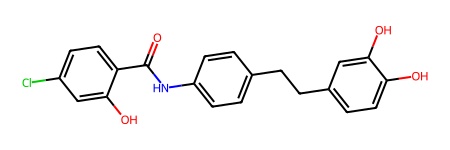

In [28]:
print(f'String for compound below is: {df_data.canonical_smiles[0]}')
Chem.MolFromSmiles(df_data.canonical_smiles[0])

In [29]:
samples = (model.generate(initial_str='C', prediction_len=10000, temperature=0.99))  # Let's Make the compounds start with a Carbo

In [30]:
samples

'C)sc1N\nCCCCNC(=O)c1cc(CCC)sc1N\nCCCCCCCCCCCCCCCCCCCCCCC(=O)c1cc(-c2ccc(Cl)cc2)n1\nCCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1\nCCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)Cc1ccc(Cl)cc1\nCCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CSc1nc2ccccc2[nH]1\nCCCCCNC(=O)c1cc2ccc(Cl)cc2[nH]1\nO=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1I\nO=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1C(F)(F)F\nO=C(Nc1ccc(F)cc1Cl)c1n[nH]c(C(F)(F)F)c1Cl\nCc1c(C(=O)Nc2ccc(F)cc2Cl)n[nH]1\nO=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1C(F)(F)F\nO=C(Nc1ccc(F)cc1Cl)c1cc(C(F)(F)F)[nH]n1\nCc1ccc(C(C)(C)C)c(O)c(C(C)(C)C)c1\nCCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CC1CCC1\nCCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1OC\nCCCNC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)C[C@H](C)CCCC(C)C\nCCCCCCCC(=O)c1cc(-c2ccccc2)sc1N\nCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCNC(=O)c1cc(C)sc1N\nCCCCCCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12\nCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12\nCCCCCC(=O)c1c(C(=O)OCC)[nH]n1\nCOc1ccc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)c(OC[C@@H](O)[C@@H](O)COC)OC(

In [31]:
Potential_Smiles_list = [line.strip() for line in samples.split('\n')]
print(f'We have Generated {len(Potential_Smiles_list)} Potential Smiles.')

We have Generated 185 Potential Smiles.


In [32]:
# Apply the CHEM.MOLFromSmiles function from RDKIT
List_of_Molecules = np.array([Chem.MolFromSmiles(s) for s in Potential_Smiles_list])

[08:06:07] SMILES Parse Error: extra close parentheses while parsing: C)sc1N
[08:06:07] SMILES Parse Error: Failed parsing SMILES 'C)sc1N' for input: 'C)sc1N'
[08:06:07] Can't kekulize mol.  Unkekulized atoms: 1 2 14
[08:06:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 11 16
[08:06:07] Can't kekulize mol.  Unkekulized atoms: 7 8 15
[08:06:07] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)c(OC[C@@H](O)[C@@H](O)COC)OC(=O)C=C4O[C@@]3(C)CC[C@@H]12
[08:06:07] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)c(OC[C@@H](O)[C@@H](O)COC)OC(=O)C=C4O[C@@]3(C)CC[C@@H]12' for input: 'COc1ccc(C(C)(C)C)c(O)c(C(C)(C)C)c1)c1cc(C(C)(C)C)c(OC[C@@H](O)[C@@H](O)COC)OC(=O)C=C4O[C@@]3(C)CC[C@@H]12'
[08:06:07] SMILES Parse Error: extra open parentheses for input: 'CC1(C)CCC[C@]2(C)[C@H]1C[C@@H](O)[C@H](Cc1cc(O)c(O)cc1[N+](=O)[O-]'
[08:06:07] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[0

In [33]:
print("Percentage of Invalid Generated Compounds: ")
(List_of_Molecules == None).sum()/len(List_of_Molecules)
     

Percentage of Invalid Generated Compounds: 


0.42162162162162165

In [34]:
List_of_REAL_Molecules = List_of_Molecules[(List_of_Molecules != None)]
smiles_list = [Chem.MolToSmiles(mol) for mol in List_of_REAL_Molecules]

In [35]:
smiles_list

['CCCCNC(=O)c1cc(CCC)sc1N',
 'CCCCCCCCCCCCCCCCCCCCCCC(=O)C1=CC(c2ccc(Cl)cc2)=N1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)Cc1ccc(Cl)cc1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CSc1nc2ccccc2[nH]1',
 'CCCCCNC(=O)c1cc2ccc(Cl)cc2[nH]1',
 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1I',
 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1C(F)(F)F',
 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]c(C(F)(F)F)c1Cl',
 'O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1C(F)(F)F',
 'O=C(Nc1ccc(F)cc1Cl)c1cc(C(F)(F)F)[nH]n1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CC1CCC1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1OC',
 'CCCNC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)C[C@H](C)CCCC(C)C',
 'CCCCCCCC(=O)c1cc(-c2ccccc2)sc1N',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCNC(=O)c1cc(C)sc1N',
 'CCCCCCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12',
 'CCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12',
 'CC(=O)c1cc2ccc(Cl)cc2[nH]1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)C1CCN(C(=O)OC(C)(C)C)CC1',
 'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(

In [36]:
print(f'We have Generated {len(smiles_list)} real compounds.')

We have Generated 107 real compounds.


The following compound has SMILES notation: CCCCNC(=O)c1cc(CCC)sc1N


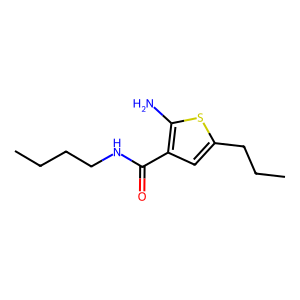

The following compound has SMILES notation: CCCCCCCCCCCCCCCCCCCCCCC(=O)C1=CC(c2ccc(Cl)cc2)=N1


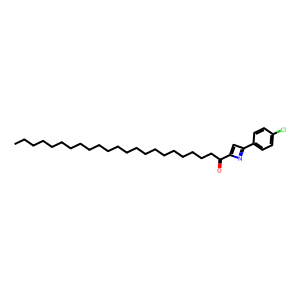

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1


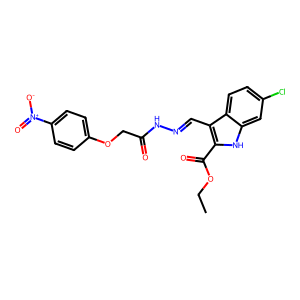

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)Cc1ccc(Cl)cc1


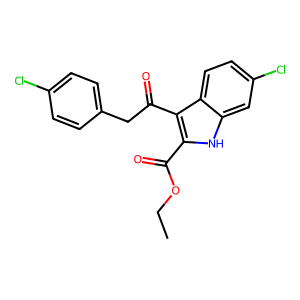

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CSc1nc2ccccc2[nH]1


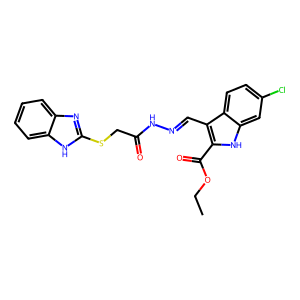

The following compound has SMILES notation: CCCCCNC(=O)c1cc2ccc(Cl)cc2[nH]1


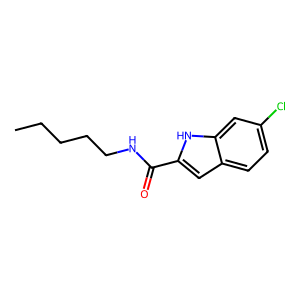

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1I


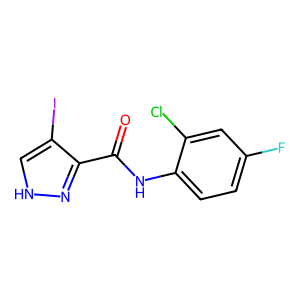

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1C(F)(F)F


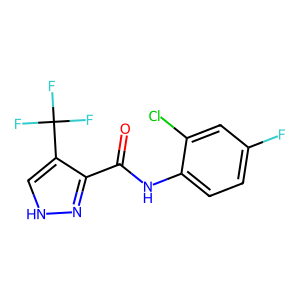

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1n[nH]c(C(F)(F)F)c1Cl


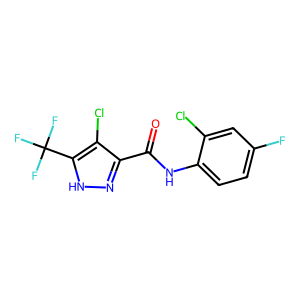

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1C(F)(F)F


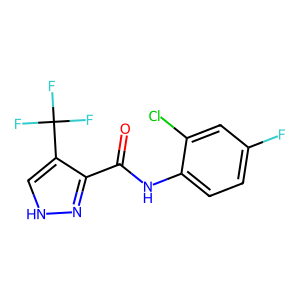

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1cc(C(F)(F)F)[nH]n1


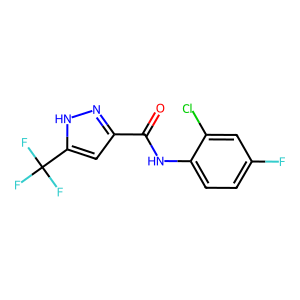

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CC1CCC1


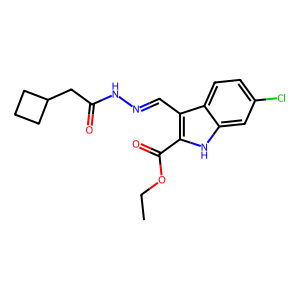

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1OC


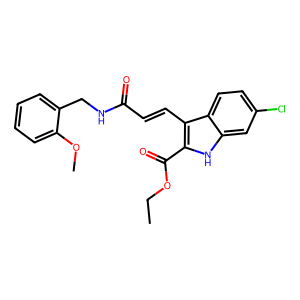

The following compound has SMILES notation: CCCNC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)C[C@H](C)CCCC(C)C


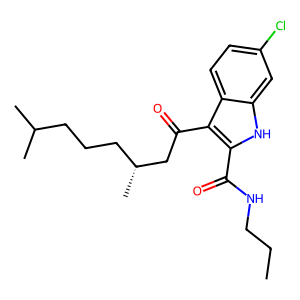

The following compound has SMILES notation: CCCCCCCC(=O)c1cc(-c2ccccc2)sc1N


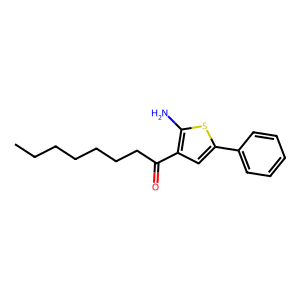

The following compound has SMILES notation: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCNC(=O)c1cc(C)sc1N


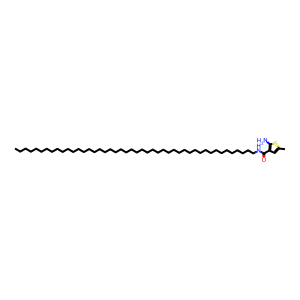

The following compound has SMILES notation: CCCCCCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


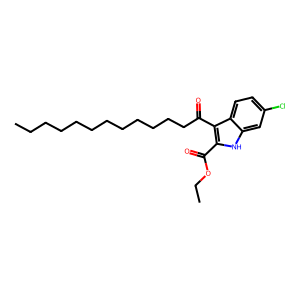

The following compound has SMILES notation: CCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


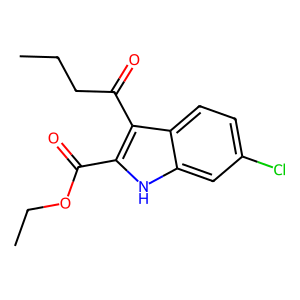

The following compound has SMILES notation: CC(=O)c1cc2ccc(Cl)cc2[nH]1


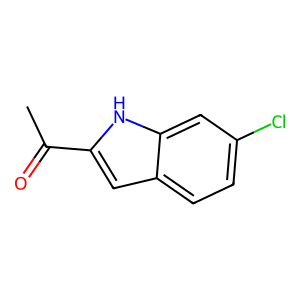

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)C1CCN(C(=O)OC(C)(C)C)CC1


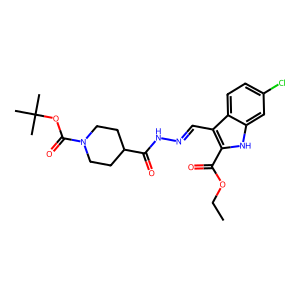

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C)=O


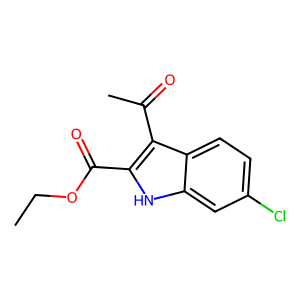

The following compound has SMILES notation: CCCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


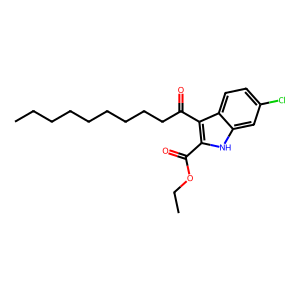

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


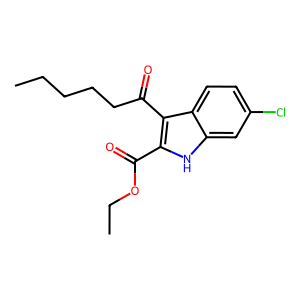

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


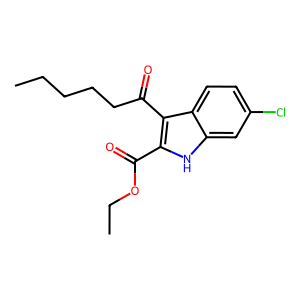

The following compound has SMILES notation: CCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


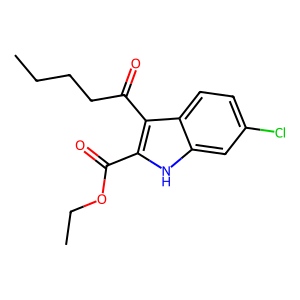

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


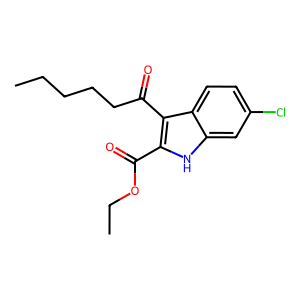

The following compound has SMILES notation: CC(=O)c1cc(O)c(O)cc1C[C@@H](C)[C@@H](C)Cc1cc(O)c(O)cc1O.[Na+]


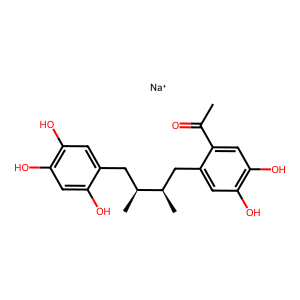

The following compound has SMILES notation: Cc1ccc(-c2cc(-c3cc(C)ccc3O)n[nH]2)cc1


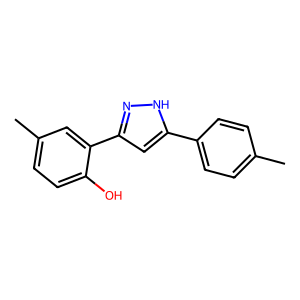

The following compound has SMILES notation: Cc1ccc(O)c(-c2cc(-c3cccc(F)c3)[nH]n2)c1


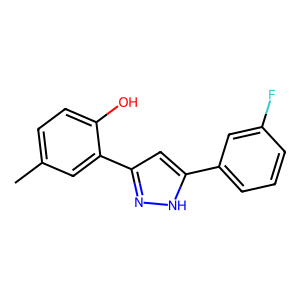

The following compound has SMILES notation: O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccccc1O


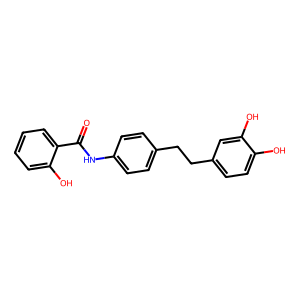

The following compound has SMILES notation: CCc1cc(NC(=O)Nc2ccc(NC(=O)c3ccccc3O)cc2)c(N)s1


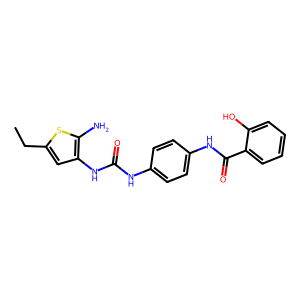

The following compound has SMILES notation: Cc1ccc(O)c(-c2cc(-c3ccccc3Cl)[nH]n2)c1


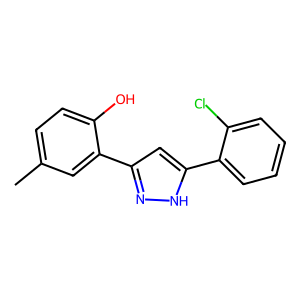

The following compound has SMILES notation: COc1ccc(O)c(O)c1


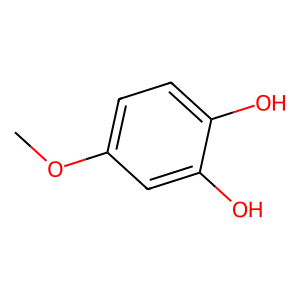

The following compound has SMILES notation: O=C(O)c1cc(C(F)(F)F)[nH]n1


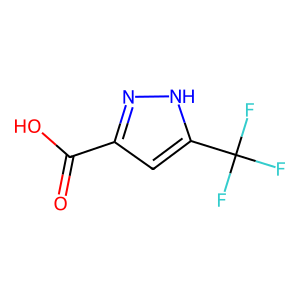

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


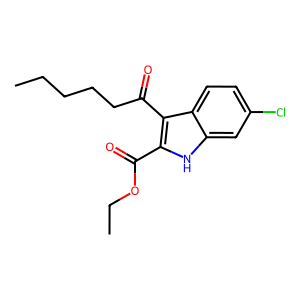

The following compound has SMILES notation: CCCC(=O)c1cc(O)c(O)cc1[N+](=O)[O-]


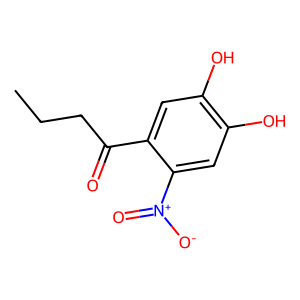

The following compound has SMILES notation: CCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


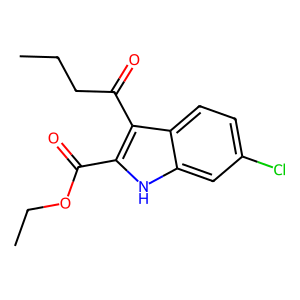

The following compound has SMILES notation: CCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


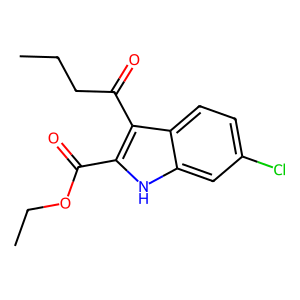

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(C)=O


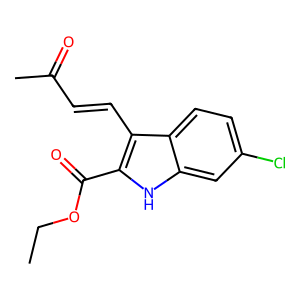

The following compound has SMILES notation: CCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


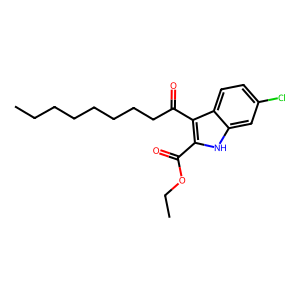

The following compound has SMILES notation: CCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


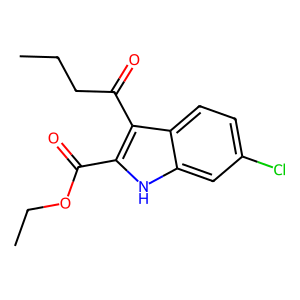

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1


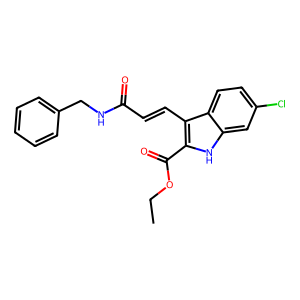

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CC1CCC1


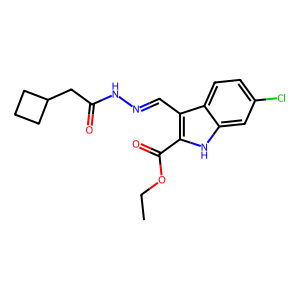

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)C[C@H](C)CCCC(C)C


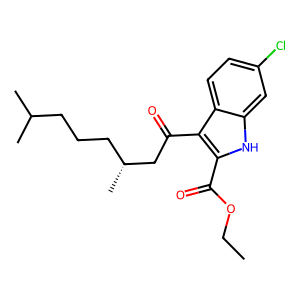

The following compound has SMILES notation: CCCCCCCCCCCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


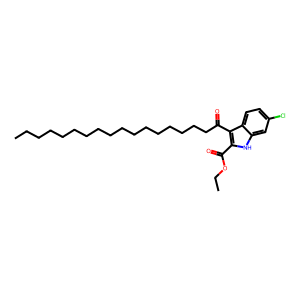

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


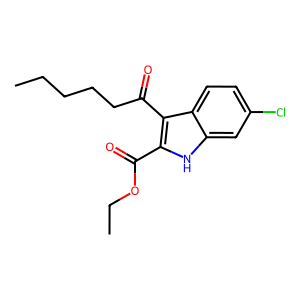

The following compound has SMILES notation: CCCC(C)NC(=O)c1cc(CC)sc1N


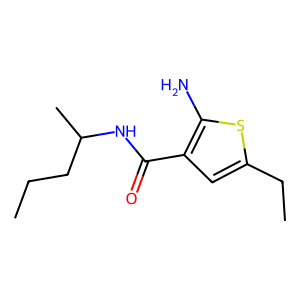

The following compound has SMILES notation: CCCCCCCCCC=C(C)CCCCc1ccoc1


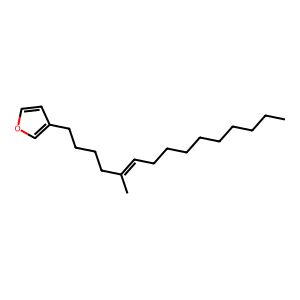

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(C)=C/COc1ccccc1


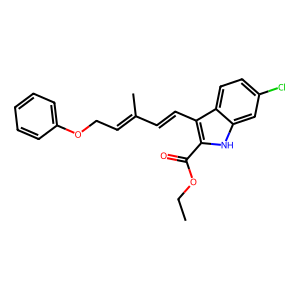

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1cc([N+](=O)[O-])[nH]n1


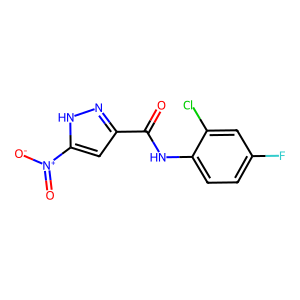

The following compound has SMILES notation: Nc1c[nH]nc1C(=O)Nc1ccc(F)cc1


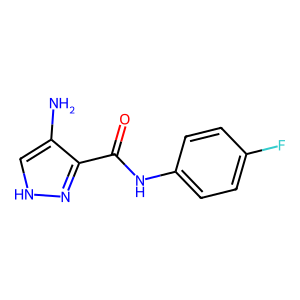

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(=O)Cc1ccccc1


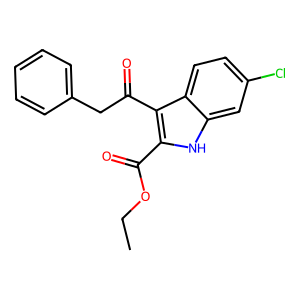

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1)c1cn[nH]n1


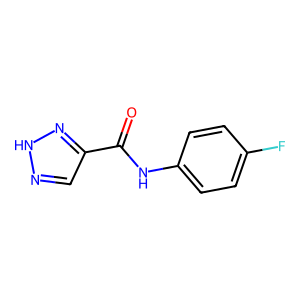

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1)c1cn[nH]n1


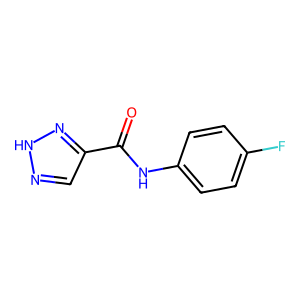

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1)c1cn[nH]n1


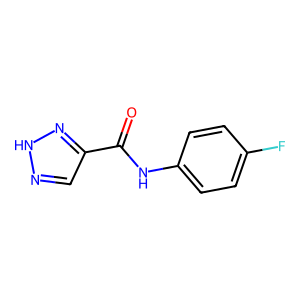

The following compound has SMILES notation: O=C(Nc1ccccc1Cl)c1cn[nH]n1


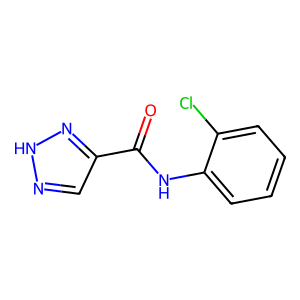

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1)c1cn[nH]n1


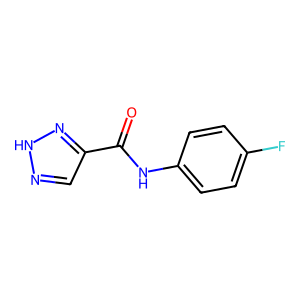

The following compound has SMILES notation: O=C(Nc1ccccc1Cl)c1cn[nH]n1


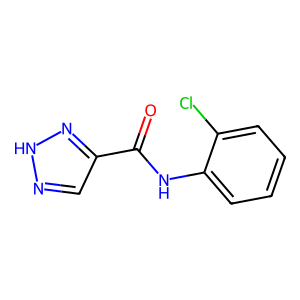

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1n[nH]cc1-c1ccccc1


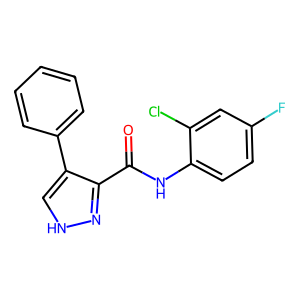

The following compound has SMILES notation: O=C(Nc1ccccc1)c1cn[nH]n1


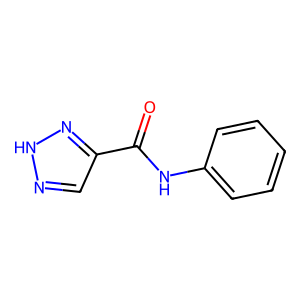

The following compound has SMILES notation: O=C(Nc1ccc(F)cn1)c1cn[nH]n1


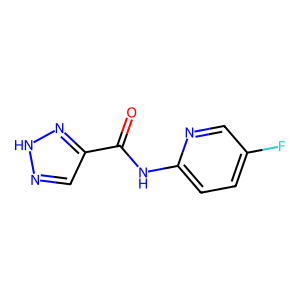

The following compound has SMILES notation: CCOC(=O)C1CCN(C(=O)CCc2cc(-c3ccc(C(F)(F)F)cc3)n(-c3ccc(Cl)nn3)n2)CC1


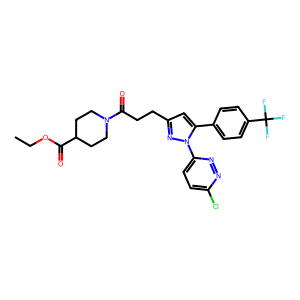

The following compound has SMILES notation: Cc1ccc(-c2cc(-c3cccc(F)c3)[nH]n2)c(O)c1


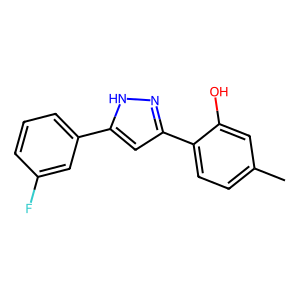

The following compound has SMILES notation: Cc1ccc(-c2cc(-c3cccc(F)c3)[nH]n2)cc1


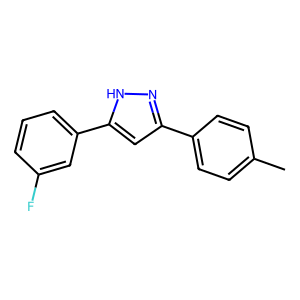

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)CC1CCC1


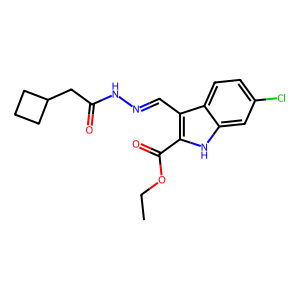

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1


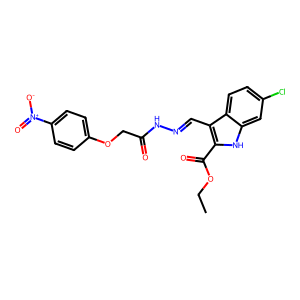

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1cccc(OC)c1


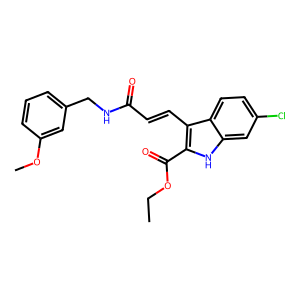

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccc(OC)cc1


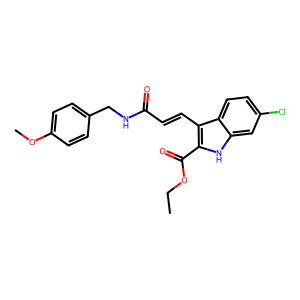

The following compound has SMILES notation: Cc1ccc(O)c(O)c1


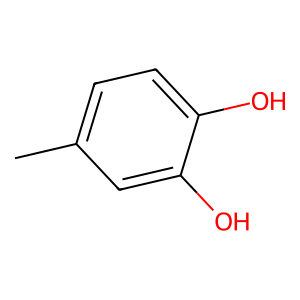

The following compound has SMILES notation: CC1=CC[C@H]2C(C)(C)CCC[C@]2(C)[C@H]1C[C@@H](OS(=O)(=O)[O-])[C@H](C)CCCC(C)C


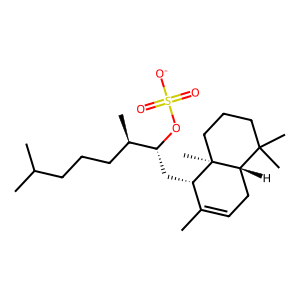

The following compound has SMILES notation: CCCCCCCCC(=O)c1cc(-c2ccccc2)sc1N


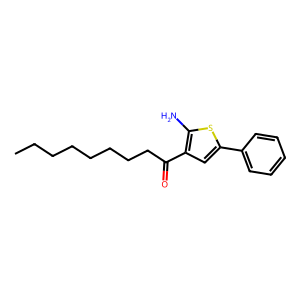

The following compound has SMILES notation: CCCCCCCCCCCCCCCCCCCCCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


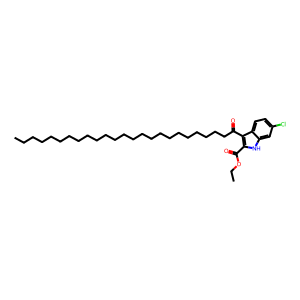

The following compound has SMILES notation: CCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


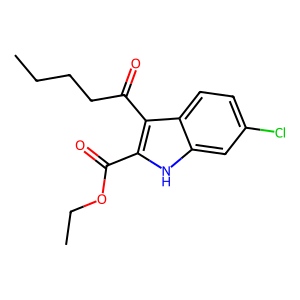

The following compound has SMILES notation: CCCC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/COc1ccc2oc(=O)ccc2c1


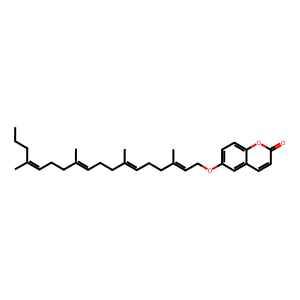

The following compound has SMILES notation: CO[C@H]1C[C@]2(O)C(C)=CC[C@H]2C(C)(C)CCC[C@]2(C)[C@H]3C(=O)c4c(cccc4C(=O)O)O[C@@]3(C)CC[C@@H]12


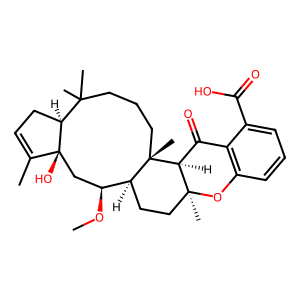

The following compound has SMILES notation: O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1)c1cccs1


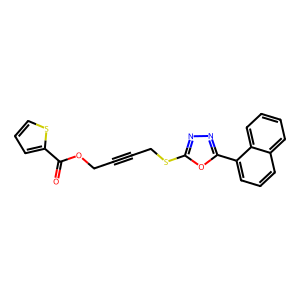

The following compound has SMILES notation: O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1)c1cc2ccccc2s1


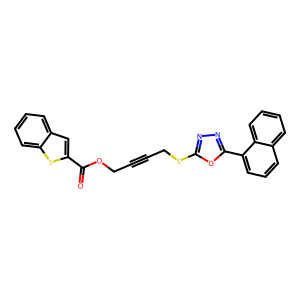

The following compound has SMILES notation: O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1)c1cc2ccccc2s1


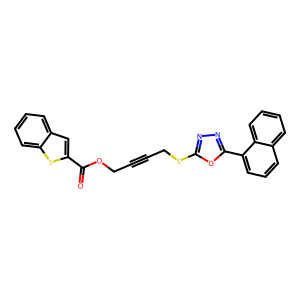

The following compound has SMILES notation: COC(=O)c1cccs1


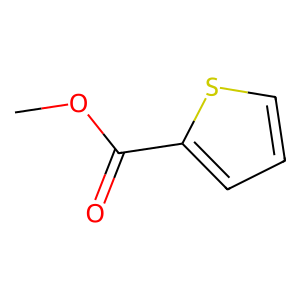

The following compound has SMILES notation: O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1)c1cccs1


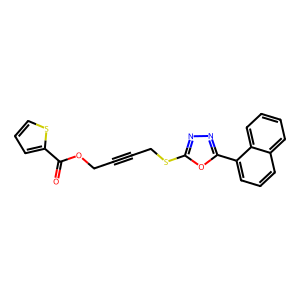

The following compound has SMILES notation: O=C(OCC#CCSc1nnc(-c2cccc3ccccc23)o1)c1ccsc1


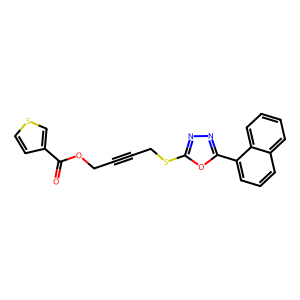

The following compound has SMILES notation: COc1ccccc1C(=O)OCC#CCSc1nnc(-c2cccc3ccccc23)o1


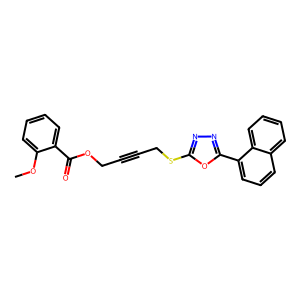

The following compound has SMILES notation: CCCCCCc1c[nH]nc1C(=O)Nc1ccc(F)cc1Cl


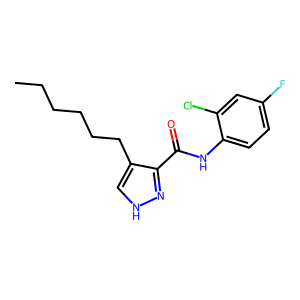

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1OC


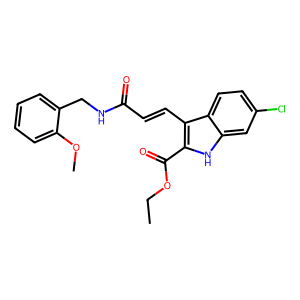

The following compound has SMILES notation: CCNC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1OC


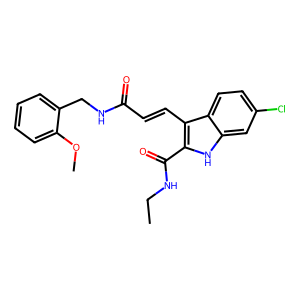

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


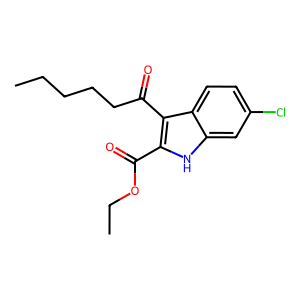

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


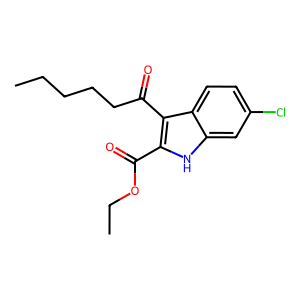

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


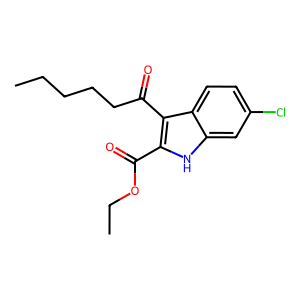

The following compound has SMILES notation: CCCCCC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)Cc1cccs1


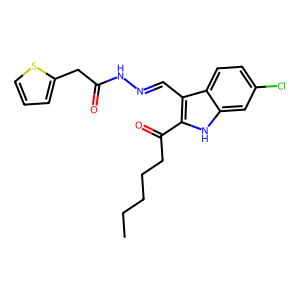

The following compound has SMILES notation: O=C(Nc1ccc(F)cc1Cl)c1n[nH]c(C(F)(F)F)c1Cl


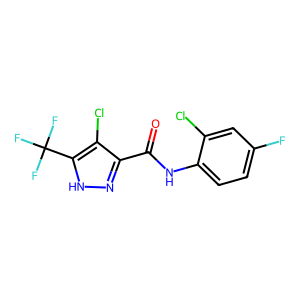

The following compound has SMILES notation: Cc1c[nH]nc1C(=O)Nc1ccc(F)cc1Cl


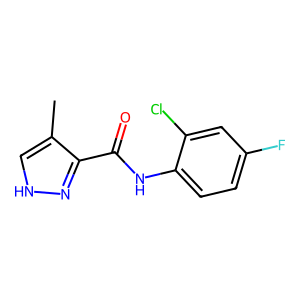

The following compound has SMILES notation: Cc1cc(C(=O)Nc2ccc(F)cc2Cl)n[nH]1


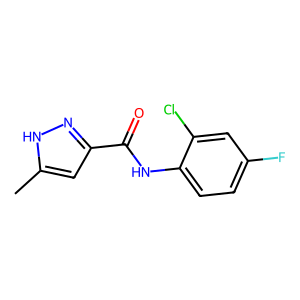

The following compound has SMILES notation: CCCCc1c[nH]nc1C(=O)Nc1ccc(F)cc1Cl


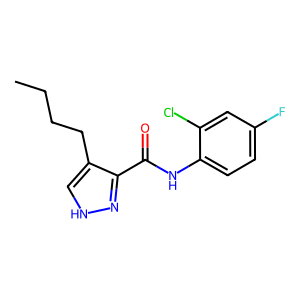

The following compound has SMILES notation: CC(C)(C)C


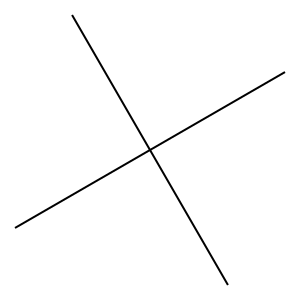

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1


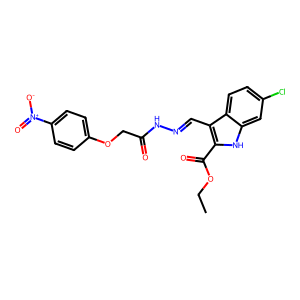

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1


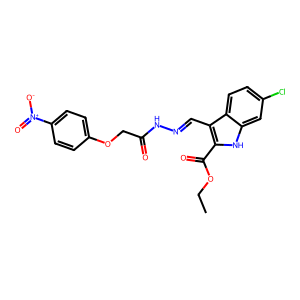

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)Cc1ccccc1


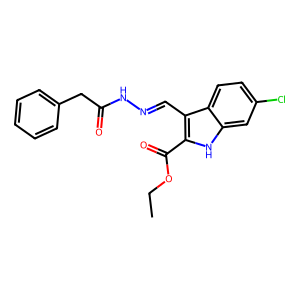

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccccc1OC


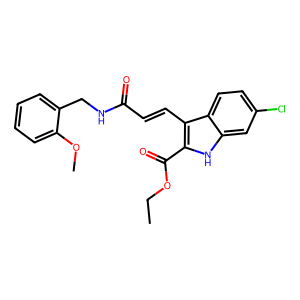

The following compound has SMILES notation: CCCNC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccc([N+](=O)[O-])cc1


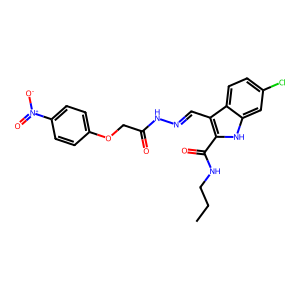

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)C1CCN(C(=O)OC(C)(C)C)CC1


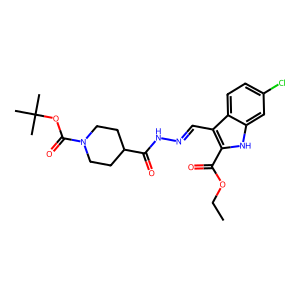

The following compound has SMILES notation: CCOC(=O)C1=C2C=C(Cl)C=C2N1


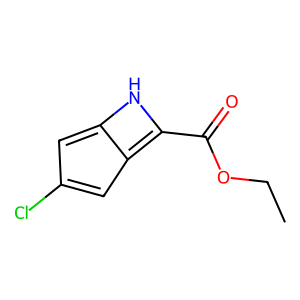

The following compound has SMILES notation: CCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


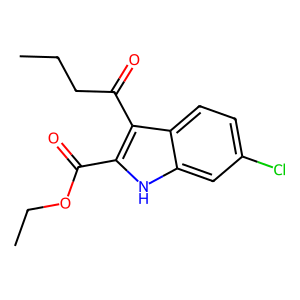

The following compound has SMILES notation: CCCCCC(=O)c1c(C(=O)OCC)[nH]c2cc(Cl)ccc12


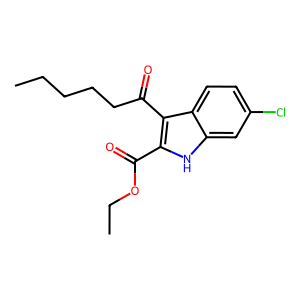

The following compound has SMILES notation: CC(=O)c1cc(O)c(O)cc1C[C@@H](C)[C@@H](C)Cc1cc(O)c(O)cc1[N+](=O)[O-]


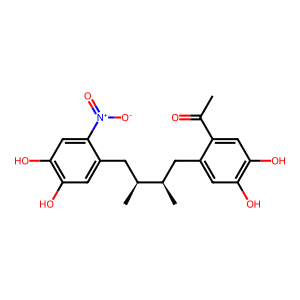

The following compound has SMILES notation: COc1ccc(CCCCc2ccc(C)c(O)c2)cc1O


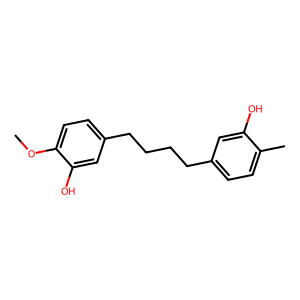

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=N/NC(=O)COc1ccccc1Cl


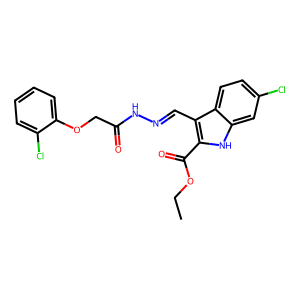

The following compound has SMILES notation: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1/C=C/C(=O)NCc1ccc(OC)cc1


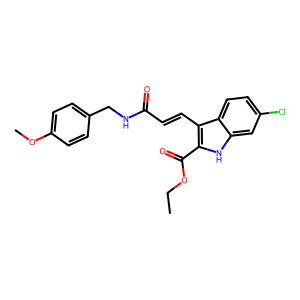

In [38]:
from IPython.display import display

for i, smiles in enumerate(smiles_list):  # Iterate over the list of SMILES strings
    print(f'The following compound has SMILES notation: {smiles}')
    mol = Chem.MolFromSmiles(smiles)  # Convert the SMILES string to an RDKIT Mol object
    img = Chem.Draw.MolToImage(mol)  # Generate an image of the molecule
    display(img)  # Display the image in the notebook
    img.save(f'mol_{i}.png')

In [ ]:
#So far so good, will tweak the parameters! 